# "Building a Language Model for Chinese Numbers using LSTM and GRU"
> "Make a dataset of Chinese numbers and train language models for it with LSTM and GRU which are built from scratch."
- toc:true
- branch: master
- badges: true
- comments: true
- author: Peiyi Hung
- categories: [category, project, RNN, fastai, pytorch]
- image: "images/vanillaRNN.png"

# Introduction

In order to better understand what are a language model and recurrent neural networks (RNN), I create a simple dataset on Chinese numbers and train various RNNs to build a language model of Chinese numbers in this project. The dataset contains Traditional Chinese characters of numbers from 0 to 9999 and I train models to predict the next Chinese number in the dataset.  Most models are built by common modules in Pytorch instead of off-the-shelf Pytorch RNN moduels. For example, I make LSTM cells using only `nn.Linear` rather than `nn.LSTM`. Only the last model are created using Pytorch's `nn.LSTM` and, by adding regularization techniques, it yields an accuracy of 96%. This project is inspired by the chapter 12 of [the fastai book](https://github.com/fastai/fastbook) in which the author creates a dataset of English numbers and trains language models.

# Generate data

Here's how I make this simple model of Chinese numbers:

In [1]:
from fastai.text.all import *

# generate numbers from 0 to 9
zero_to_nine = ["零", "一", "二", "三", "四", "五", "六", "七", "八", "九"]
num = zero_to_nine.copy()

# 10 to 19
ten_to_nineteen = []
for i in zero_to_nine:
    if i == "零":
        add = ""
    else:
        add = i
    ten_to_nineteen.append("十" + add)
num += ten_to_nineteen

# 20 to 99
ten_to_hundred = [i+j for i in zero_to_nine[2:] for j in ten_to_nineteen]
num += ten_to_hundred

# 100 to 999
hundred_to_thousand = []
for i in zero_to_nine[1:]:
    hundred_to_thousand.append(i + "百")
    for g in zero_to_nine[1:]:
        hundred_to_thousand.append(i + "百" + "零" + g)
    for j in ten_to_nineteen:
        hundred_to_thousand.append(i + "百" + "一" + j)
    for k in ten_to_hundred:
        hundred_to_thousand.append(i + "百" + k)
num += hundred_to_thousand

# 999 to 9999
thousand_tenthousand = []
for i in zero_to_nine[1:]:
    thousand_tenthousand.append(i + "千")
    for g in zero_to_nine[1:]:
        thousand_tenthousand.append(i + "千" + "零" + g)
    for j in ten_to_nineteen:
        thousand_tenthousand.append(i + "千" + "零"+ "一" + j)
    for k in ten_to_hundred:
        thousand_tenthousand.append(i + "千" + "零" + k)
    for o in hundred_to_thousand:
        thousand_tenthousand.append(i + "千" + o)

num += thousand_tenthousand

Let's take a look at the dataset:

In [2]:
len(num)

10000

In [3]:
num[100:111]

['一百',
 '一百零一',
 '一百零二',
 '一百零三',
 '一百零四',
 '一百零五',
 '一百零六',
 '一百零七',
 '一百零八',
 '一百零九',
 '一百一十']

The numbers in the dataset are from 0 to 9999, so there are 10000 data points in it. If you want to save this dataset, you can uncomment and execute the following codes:

In [4]:
# # write into a file, "chinese_numers.txt"
# with open("chinese_numbers.txt", "w") as text_file:
#     text_file.write("\n".join(num))

# Tokenization and Numericalization

Before we delve into modeling, we should first make our dataset understandable by the model. That is, we should tokenize the data and numericalize the tokens. 

Tokenization is to transfer each Chinese character into a token.

In [5]:
tokens = L(n for n in ".".join(num) if n)
tokens

(#74691) ['零','.','一','.','二','.','三','.','四','.'...]

`vocab` is the collection of unique tokens.

In [6]:
vocab = L(*tokens).unique()

Numericalization is to map a token to a non-negative number so as to be taken by the `nn.Embedding` layer of RNNs.

In [7]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#74691) [0,1,2,1,3,1,4,1,5,1...]

# Dataloaders

Next, we rearrange the data into batches and form the dataloaders

In [8]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs)) 
    return new_ds

In [9]:
sl = 16 # sequence length
bs = 32 # batch size
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

Let's see how the data is formed in a batch:

In [10]:
xs, y = dls.one_batch()

In [17]:
L(vocab[i] for i in xs[0])

(#16) ['零','.','一','.','二','.','三','.','四','.'...]

In [16]:
L(vocab[i] for i in y[0])

(#16) ['.','一','.','二','.','三','.','四','.','五'...]

For each time step, the model is predicting the next word given previous word, so the independent variable is a sequence of tokens and the target would be the next word.

# Models

In this section, I create RNN models for the language model task. Here's a list of models:
* vanilla RNN
* two-layered RNN
* LSTM
* two-layered LSTM
* GRU
* LSTM + regularization 

The last one uses Pytorch's `nn.LSTM`, while the rest only use `nn.Linear` and `nn.Embedding` modules. All the models would be trained using cross entropy as loss function, Adam as optimization method and accuracy as evaluation metric.

## Vanilla RNN

The first model is a RNN with only plain linear layers in it.

In [11]:
class VanillaRNN(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        
        # walking through each time step
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

This model is composed of:
* `self.i_h`: an embedding layer (`nn.Embedding`) taking into a index of a token and return the embedding vector of a token.
* `self.h_h`: a plain linear layer taking the vector of word and performing linear transformation
* `self.h_o`: the output layer generating the probability of being each word in the `vocab`
* `self.h`: the hidden state of the RNN

Let's train this model:

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.009120108559727669)

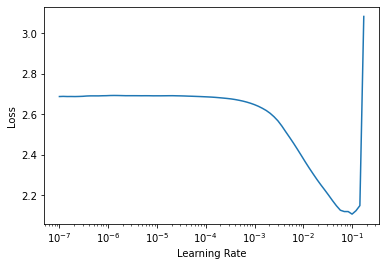

In [12]:
learn1 = Learner(dls, VanillaRNN(len(vocab), 128), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn1.lr_find()

In [13]:
learn1.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.479430,1.525608,0.455280,00:01
1,1.121994,1.544240,0.526670,00:01
2,0.921751,1.768980,0.579270,00:01
3,0.737316,1.990620,0.618400,00:01
4,0.612017,2.001600,0.637998,00:01
5,0.520435,2.110346,0.662985,00:01
6,0.432043,2.188616,0.696862,00:01
7,0.357842,2.515358,0.727910,00:01
8,0.302256,2.760709,0.741110,00:01
9,0.252840,2.879565,0.750606,00:01


We get 75% accuracy after 10 epochs.

## Two-layered RNN

You can stack multiple linear layers in a RNN to make you model more powerful. Here I make a two-layered one.

In [14]:
class TwoLayersRNN(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h1 = nn.Linear(n_hidden, n_hidden)
        self.h_h2 = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h1 = 0
        self.h2 = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h1 = self.h1 + self.i_h(x[:,i])
            self.h1 = F.relu(self.h_h1(self.h1))
            self.h2 = self.h2 + self.h1
            self.h2 = F.relu(self.h_h2(self.h2))
            outs.append(self.h_o(self.h2))
        self.h1 = self.h1.detach()
        self.h2 = self.h2.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): 
        self.h1 = 0
        self.h2 = 0

This model is also a RNN with plain linear layers but it has two linear layers. You can find the two linear layers in the codes:`self.h_h1` and `self.h_h2`. Let's see if it can outperform the single-layered one.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.005248074419796467)

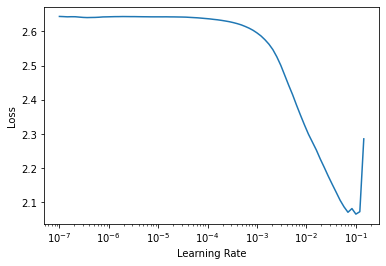

In [46]:
learn2 = Learner(dls, TwoLayersRNN(len(vocab), 128), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn2.lr_find()

In [47]:
learn2.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.432051,1.517559,0.454337,00:01
1,1.138805,1.898586,0.539601,00:01
2,0.823014,2.276638,0.555900,00:01
3,0.629227,1.774288,0.618871,00:01
4,0.507961,1.674384,0.629782,00:01
5,0.400248,1.949680,0.659079,00:01
6,0.352511,1.605654,0.693427,00:01
7,0.252898,1.634336,0.752155,00:01
8,0.212198,1.842869,0.764547,00:01
9,0.177986,1.873169,0.770205,00:02


This model get 2% increase in accuracy also with 10 epcohs as the previous one.

The vanilla RNN severely suffers from the vanishing gradient problem. To resolve the problem, several cell architectures are designed including [Long Short-term Memory (LSTM)](https://www.bioinf.jku.at/publications/older/2604.pdf) and [Gated Recurrent Unit (GRU)](https://arxiv.org/abs/1406.1078v3). I would implement these two method with Pytorch in the following sections.

## Long Short-Term Memory (LSTM)

Instead of using a linear layer, LSTM use a much more sophisticated cells in a RNN. Here's the cell in codes:

In [33]:
# LSTM cell
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni+nh, nh)
        self.input_gate = nn.Linear(ni+nh, nh)
        self.outout_gate = nn.Linear(ni+nh, nh)
        self.cell_gate = nn.Linear(ni+nh, nh)
        self.n_size = ni+nh
    
    def forward(self, input_, state):
        # h and c from last time step, concatenate them into a single vector
        h, c = state
        h = torch.stack([h, input_], dim=1).view(-1, self.n_size)
        
        # gates
        forget = torch.sigmoid(self.forget_gate(h))
        inp = torch.sigmoid(self.input_gate(h))
        output = torch.sigmoid(self.outout_gate(h))
        
        # update or forget content
        cell = torch.tanh(self.cell_gate(h))
        c = forget * c + inp*cell
        h = torch.tanh(c) * output
        return h, (h, c)
        

In a LSTM cell, two states would be passed through the network: hidden state `h` and cell state `c`. Hidden state and the input (`input_`) at each time step would be concatenated together first.
```
h = torch.stack([h, input_], dim=1).view(-1, self.n_size)
```
And then they would be passed into three gates: forget gate, input gate, and output gate. 
```
forget = torch.sigmoid(self.forget_gate(h))
inp = torch.sigmoid(self.input_gate(h))
output = torch.sigmoid(self.outout_gate(h))

```
Since these three gates all use sigmoid function as activation function, they would produce three scores ranging from 0 to 1. A new cell state would be computed by passing hidden state into the cell state and then the tanh function. 
```
cell = torch.tanh(self.cell_gate(h))
```
The updated cell state would be a weighted average of the previous cell state and the one that's newly computed. The weights are the output of forget gate and input gate.
```
c = forget * c + inp * cell
```
This new cell state would also be passed into the tanh function and times the output gate score becoming the new hidden state.
```
h = torch.tanh(c) * output
```

There are two sets of output of the LSTM cell: `h` is the output of each time step and `(h, c)` are the states passed into the next time step.

Let's bulid a LSTM RNN and train it:

In [33]:
# build a RNN applying LSTM cell
class MyLSTM(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = LSTMCell(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(bs, n_hidden)
        self.c = torch.zeros(bs, n_hidden)

    def forward(self, x):
        out = []
        state = (self.h, self.c)
        for i in range(sl):
            output, state = self.rnn(self.i_h(x[:,i]), state)
            out.append(self.h_o(output))
        self.h = self.h.detach()
        self.c = self.c.detach()
        return torch.stack(out, dim=1)
    
    def reset(self): 
        self.h = self.h.zero_()
        self.c = self.c.zero_()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.009120108559727669)

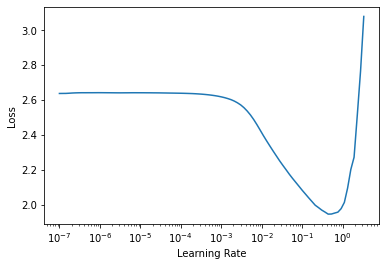

In [36]:
learn3 = Learner(dls, MyLSTM(len(vocab), 128), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn3.lr_find()

In [35]:
learn3.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.564131,1.658502,0.413254,00:06
1,1.132675,1.635722,0.495824,00:06
2,0.874189,1.553444,0.536099,00:06
3,0.682400,1.353059,0.626549,00:06
4,0.529528,1.235760,0.652883,00:06
5,0.461710,1.070935,0.693023,00:06
6,0.435143,1.129873,0.695043,00:06
7,0.417539,1.090291,0.706897,00:05
8,0.400883,1.208046,0.708176,00:05
9,0.392933,1.203122,0.707099,00:06


We train it for 10 epochs and this model use only get 70% accuracy. There may be some other problems we have to deal with.

## Two-layered LSTM

As in the vanilla RNN, we can also stack LSTM cells. I create a two-layered one here.

In [69]:
class MyLSTM2(Module):
    def __init__(self, vocab_sz, n_hidden):
        # networks
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn1 = LSTMCell(n_hidden, n_hidden)
        self.rnn2 = LSTMCell(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        
        # hidden states, 2 layers and 2 states each layer
        self.hs = [torch.zeros(bs, n_hidden) for _ in range(4)]
        
    def forward(self, x):
        out = []
        
        # initial hidden states
        state1 = [self.hs[i] for i in [0,1]]
        state2 = [self.hs[i] for i in [2,3]]
        
        # go through all networks
        for i in range(sl):
            output, state1 = self.rnn1(self.i_h(x[:,i]), state1)
            output, state2 = self.rnn2(output, state2)
            out.append(self.h_o(output))
            
        # detach hidden states
        for i in range(4):
            self.hs[i] = self.hs[i].detach()
            
        return torch.stack(out, dim=1)
    
    def reset(self): 
        for i in range(4):
            self.hs[i] = self.hs[i].zero_()

Since we have two LSTM cells in the RNN, two sets of states are computed (`state1` and `state2`). The output hidden state of the first LSTM cell would be passed into the next LSTM cell and the next LSTM cell would generate the probability of each word.

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.019054606556892395)

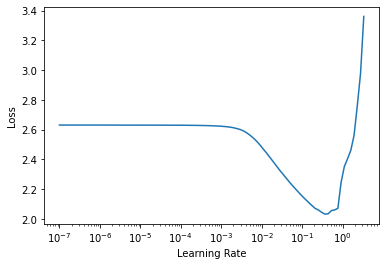

In [70]:
learn4 = Learner(dls, MyLSTM2(len(vocab), 128), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn4.lr_find()

In [52]:
learn4.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.367824,1.692747,0.461072,00:06
1,1.101825,1.752430,0.499663,00:06
2,0.887319,1.522436,0.534079,00:05
3,0.752598,1.426126,0.591123,00:07
4,0.645684,1.208018,0.659011,00:05
5,0.572723,1.224382,0.638200,00:06
6,0.514688,1.094028,0.664130,00:06
7,0.484465,1.107556,0.669114,00:05
8,0.458131,1.096884,0.675647,00:05
9,0.444725,1.108794,0.673155,00:05


## Gated Recurrent Unit (GRU)

GRU also attempts to address vanishing gradient problem as LSTM but it is less complicated than LSTM.

In [ ]:
class GRUcell(Module):
    def __init__(self, ni, nh):
        self.u_gate = nn.Linear(ni+nh, nh)
        self.r_gate = nn.Linear(ni+nh, nh)
        self.g = nn.Linear(ni+nh, nh)
        self.n_size = ni+nh
        
    def forward(self, x, h):
        # combine h from last time step and x from this time step
        h_t = torch.stack([h, x], dim=1).view(-1, self.n_size)
        
        # update gate and reset gate
        u = torch.sigmoid(self.u_gate(h_t))
        r = torch.sigmoid(self.r_gate(h_t))
        
        # update or rest content
        rh = h * r
        x_rh = torch.stack([x, rh], dim=1).view(-1, self.n_size)
        g = torch.tanh(self.g(x_rh))
        return u*h + (1-u)*g

In contrast to a LSTM cell, a GRU cell only has one hidden state (`h`) and two gates (`self.u_gate` and `self.r_gate`). As in the LSTM cell, the hidden state and the input at current time step would first be stacked together.
```
h_t = torch.stack([h, x], dim=1).view(-1, self.n_size)
```
This hidden state would be passed into two gates: update gate and reset gate.
```
u = torch.sigmoid(self.u_gate(h_t))
r = torch.sigmoid(self.r_gate(h_t))
```
Next, we compute a new hidden state.
```
rh = h * r
x_rh = torch.stack([x, rh], dim=1).view(-1, self.n_size)
g = torch.tanh(self.g(x_rh))
```
The final output is a weighted average of the original hidden state and the new hidden state.
```
u * h + (1-u) * g
```

Let's apply this GRU cell to a RNN and train this RNN:

In [ ]:
class MyGRU(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = GRUcell(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(bs, n_hidden)

    def forward(self, x):
        out = []
        for i in range(sl):
            self.h = self.rnn(self.i_h(x[:,i]), self.h)
            out.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(out, dim=1)
    
    def reset(self): 
        self.h.zero_()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.009120108559727669)

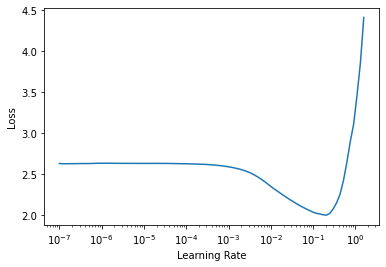

In [141]:
learn5 = Learner(dls, MyGRU(len(vocab), 128), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn5.lr_find()

In [143]:
learn5.fit_one_cycle(10, lr_max=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.505964,1.656996,0.391501,00:03
1,1.137567,1.522142,0.539534,00:03
2,0.768740,1.856354,0.604054,00:03
3,0.494808,1.249206,0.647495,00:03
4,0.296579,1.079444,0.737204,00:03
5,0.154340,0.889941,0.789871,00:03
6,0.091274,0.959103,0.833311,00:03
7,0.057189,0.823301,0.849811,00:03
8,0.032112,0.825291,0.856075,00:03
9,0.024684,0.823506,0.856883,00:03


Surprisingly, this GRU model gets 85% accuray which is much better than the LSTM one.

> Note: LSTM and GRU makes it easier to retain long-term information by adjusting those gates.

## LSTM + Regularization techniques

To get a good performance, the last model I train uses Pytorch's `nn.LSTM` module and serveral regularization techniques.

In [58]:
class LSTM_with_regularization(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.007585775572806597)

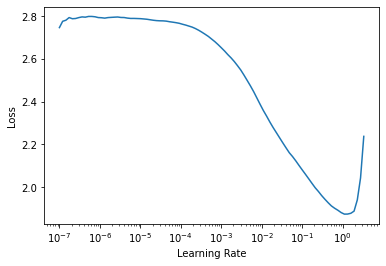

In [67]:
learn6 = Learner(dls, LSTM_with_regularization(len(vocab), 128, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])
learn6.lr_find()

In this model, three regularization method are used:
* **Dropout**: randomly setting some weights of a unit to zero, implemented with `nn.Dropout`, the probability is set to 0.5.
* **Activation Regularization (AR) and Temporal Activation Regularization (TAR)**: Similar to weight decay, trying to make the activation (AR) and the difference between consecutive activations (TAR) as small as possible, implemented with the callback `RNNRegularizer`.
* **Weight tying**: setting the input embedding equal to the output embedding, `self.h_o.weight = self.i_h.weight` in the code.

In [68]:
learn6.fit_one_cycle(6, 1e-2, wd=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,1.069000,0.940814,0.658540,00:05
1,0.348538,0.325210,0.894868,00:04
2,0.183276,0.245054,0.917565,00:04
3,0.138813,0.188584,0.956829,00:04
4,0.114447,0.170680,0.958648,00:04
5,0.102175,0.182135,0.954943,00:04


This final model gets a great accuracy of 95.5%!

# Summary